In [1]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.stats import ranksums
import gseapy
from gseapy.plot import barplot, dotplot
from numpy.linalg import eigh, eig
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm
import time

import get_hic_map_of_MEFISTO_loci_ztrafo as MEFISTO

In [107]:
# Reload modules in case of modifications
reload(MEFISTO)

<module 'get_hic_map_of_MEFISTO_loci_ztrafo' from '/home/braunger/masterthesis/python_code/MEFISTO/get_hic_map_of_MEFISTO_loci_ztrafo.py'>

## Load Hi-C data of MEFISTO loci

In [3]:
data_dir = '/home/braunger/masterthesis/data/'
hic_dir = '/home/braunger/masterthesis/save/processed_hic_data/'
activity_dir = '/home/braunger/masterthesis/save/active_loci/'
save_dir = '/home/braunger/masterthesis/save/figures/MEFISTO/'
resol = 250000

In [4]:
# Selected MEFISTO loci:
# get df with the top weighted genes from MEFISTO
pos_weights = pd.read_csv(data_dir+'MOFA/top_genes_pos_0.1.csv')
pos_weights['sign'] = 'positive'
neg_weights = pd.read_csv(data_dir+'MOFA/top_genes_neg_0.1.csv')
neg_weights['sign'] = 'negative'
selected_genes = pd.concat([pos_weights, neg_weights])

## Z-Transformation

In [37]:
# Get Hi-C data for selected loci (matrices generated with get_hic_map_of_MEFISTO_loci)
IMR90 = pd.read_csv(hic_dir+'processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/MEFISTO_z-trafo.csv', index_col = 0)
old_fibroblasts = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/MEFISTO_z-trafo.csv', index_col = 0)

# conversion to long format
IMR90_long = pd.melt(IMR90.reset_index(), id_vars='chr1', var_name='chr2')
old_fibroblasts_long = pd.melt(old_fibroblasts.reset_index(), id_vars='chr1', var_name='chr2')

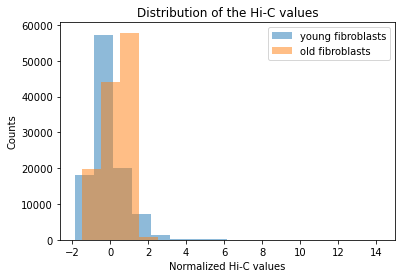

In [38]:
%matplotlib inline

binwidth = 1
plt.figure()
plt.hist(IMR90_long['value'], 
         bins=np.arange(min(IMR90_long['value']), max(IMR90_long['value']) + binwidth, binwidth), 
         alpha=0.5, label="young fibroblasts")
plt.hist(old_fibroblasts_long['value'], 
         bins=np.arange(min(old_fibroblasts_long['value']), max(old_fibroblasts_long['value']) + binwidth, binwidth), 
         alpha=0.5, label="old fibroblasts")
plt.xlabel("Normalized Hi-C values")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.title('Distribution of the Hi-C values')
plt.show()

## Ranking

In [103]:
# Get Hi-C data for selected loci (matrices generated with get_hic_map_of_MEFISTO_loci)
IMR90 = pd.read_csv(hic_dir+'processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/MEFISTO_ranks.csv', index_col = 0)
old_fibroblasts = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/MEFISTO_ranks.csv', index_col = 0)

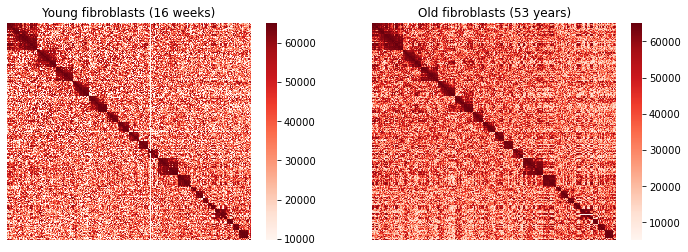

In [86]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
sns.heatmap(IMR90, cmap = "Reds", ax = axs[0], xticklabels=False, yticklabels=False)
axs[0].set_ylabel('') 
axs[0].set_title('Young fibroblasts (16 weeks)')

sns.heatmap(old_fibroblasts, cmap = "Reds", ax = axs[1], xticklabels=False, yticklabels=False)
axs[1].set_ylabel('') 
axs[1].set_title('Old fibroblasts (53 years)')
plt.show()

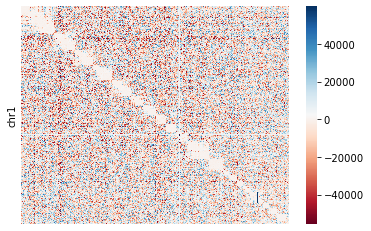

In [104]:
diff_hic = IMR90 - old_fibroblasts
sns.heatmap(diff_hic, cmap = 'RdBu', xticklabels=False, yticklabels=False)
plt.show()

In [105]:
# Get Hi-C data for random loci
IMR90 = pd.read_csv(hic_dir+'processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/random_ranks.csv', index_col = 0)
old_fibroblasts = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/random_ranks.csv', index_col = 0)

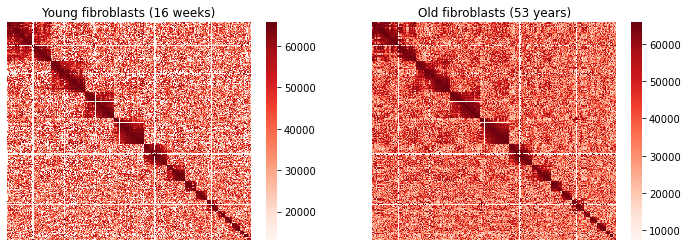

In [89]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
sns.heatmap(IMR90, cmap = "Reds", ax = axs[0], xticklabels=False, yticklabels=False)
axs[0].set_ylabel('') 
axs[0].set_title('Young fibroblasts (16 weeks)')

sns.heatmap(old_fibroblasts, cmap = "Reds", ax = axs[1], xticklabels=False, yticklabels=False)
axs[1].set_ylabel('') 
axs[1].set_title('Old fibroblasts (53 years)')
plt.show()

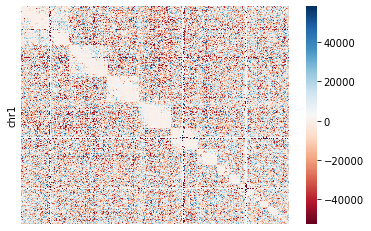

In [106]:
diff_hic_random = IMR90 - old_fibroblasts
sns.heatmap(diff_hic_random, cmap = 'RdBu', xticklabels=False, yticklabels=False)
plt.show()

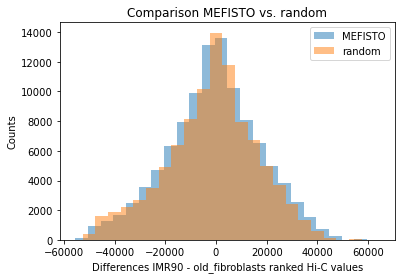

In [111]:
diff_hic.reset_index(inplace=True)
diff_hic_long = pd.melt(diff_hic, id_vars = ['chr1'])
diff_hic_long.columns = ['chr1', 'chr2', 'value']
diff_hic = diff_hic.set_index('chr1')

diff_hic_random.reset_index(inplace=True)
diff_hic_long_random = pd.melt(diff_hic_random, id_vars = ['chr1'])
diff_hic_long_random.columns = ['chr1', 'chr2', 'value']
diff_hic_random = diff_hic_random.set_index('chr1')

MEFISTO.plot_hist(diff_hic_long, diff_hic_long_random, 5000, 'Comparison MEFISTO vs. random')